In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
print(mnist.keys())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [3]:
X, y = mnist['data'], mnist['target'] 

In [4]:
import matplotlib.pyplot as plt

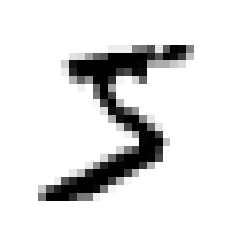

In [5]:
some_digit = X.iloc[0]
img = some_digit.values.reshape(28, 28)
plt.imshow(img, cmap='binary')
plt.axis('off')
plt.show()

In [6]:
y[0]

'5'

In [7]:
import numpy as np
y = y.astype(np.uint8)

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_cls = SGDClassifier(random_state=42)
sgd_cls.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
sgd_cls.predict(some_digit.values.reshape(1, -1))

array([ True])

In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_cls, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
for train_ind, test_ind in skfolds.split(X_train, y_train_5):
    X_train_folds = X_train.iloc[train_ind]
    y_train_5_folds = y_train_5[train_ind]
    clone_sgd = clone(sgd_cls)
    X_test_fold = X_train.iloc[test_ind]
    y_test_fold = y_train_5[test_ind]
    
    clone_sgd.fit(X_train_folds, y_train_5_folds)
    y_preds = clone_sgd.predict(X_test_fold)
    n_correct = sum(y_preds == y_test_fold)
    print(n_correct / len(y_test_fold))


0.9669
0.91625
0.96785


In [14]:
from sklearn.base import BaseEstimator

class Not5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)


In [15]:
not_5_clf = Not5Classifier()
cross_val_score(not_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [16]:
from sklearn.model_selection import cross_val_predict

y_pred_5 = cross_val_predict(sgd_cls, X_train, y_train_5, cv=3)

In [17]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_pred_5)

array([[53892,   687],
       [ 1891,  3530]])

In [18]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_pred_5)

0.8370879772350012

In [19]:
recall_score(y_train_5, y_pred_5)

0.6511713705958311

In [20]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_pred_5)

0.7325171197343846

In [21]:
y_scores = sgd_cls.decision_function([some_digit])

In [22]:
threshold = 0
y_pred_custom = (y_scores > threshold)

In [23]:
y_pred_custom

array([ True])

In [24]:
threshold = 8000
y_pred_custom = (y_scores > threshold)
y_pred_custom

array([False])

In [25]:
y_scores = cross_val_predict(sgd_cls, X_train, y_train_5, cv=3, method='decision_function')

In [26]:
from sklearn.metrics import precision_recall_curve

In [27]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [28]:
import matplotlib.pyplot as plt

def plot_precision_recall_vs_thresholds(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label = 'Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label = 'Recall')
    plt.legend(loc='center right', fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])
    plt.show()


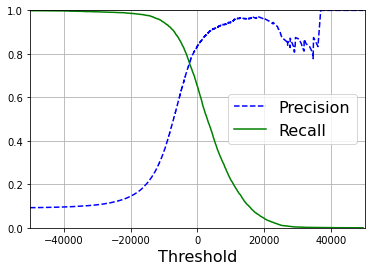

In [29]:
plot_precision_recall_vs_thresholds(precisions, recalls, thresholds)

In [30]:
threshold_90_p = thresholds[np.argmax(precisions >= 0.90)]

In [31]:
y_90_p_pred = (y_scores >= threshold_90_p)

In [32]:
precision_score(y_train_5, y_90_p_pred)

0.9000345901072293

In [33]:
recall_score(y_train_5, y_90_p_pred)

0.4799852425751706

In [34]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [35]:
def plot_roc_curve(fpr, tpr, thresholds):
    plt.plot(fpr, tpr, linewidth=2, label='ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.grid(True)


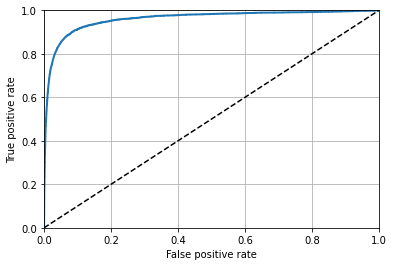

In [36]:
plot_roc_curve(fpr, tpr, thresholds)

In [38]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [39]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(random_state=42)

In [40]:
forest_y_probas = cross_val_predict(rnd_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [42]:
forest_y_probas_5 = forest_y_probas[:, 1]

In [44]:
forest_fpr, forest_tpr, thresholds = roc_curve(y_train_5, forest_y_probas_5)

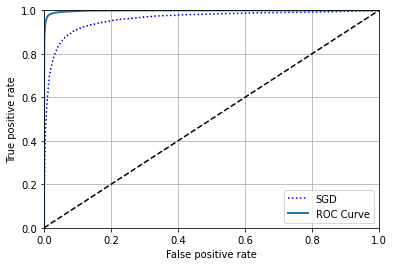

In [45]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(forest_fpr, forest_tpr, thresholds)
plt.legend(loc='lower right')
plt.show()

In [46]:
roc_auc_score(y_train_5, forest_y_probas_5)

0.9983436731328145

In [57]:
precision_score(y_train_5, forest_y_probas_5 > 0.50)

0.9905083315756169

In [58]:
recall_score(y_train_5, forest_y_probas_5 > 0.50)

0.8662608374838591

In [59]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)

SVC()

In [60]:
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [63]:
svm_clf.decision_function([some_digit])

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [64]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [66]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [67]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [68]:
len(ovr_clf.estimators_)

10

In [69]:
sgd_cls.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [70]:
sgd_cls.predict([some_digit])

array([3], dtype=uint8)

In [72]:
sgd_cls.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [73]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [74]:
sgd_clf = clone(sgd_cls)

In [75]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [76]:
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [77]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [78]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [79]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

In [80]:
X_train_scaled = std_scaler.fit_transform(X_train)

In [81]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

In [82]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [83]:
conf_mat = confusion_matrix(y_train, y_train_pred)

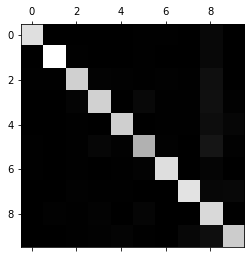

In [86]:
plt.matshow(conf_mat, cmap = plt.cm.gray)
plt.show()

In [91]:
row_sums = conf_mat.sum(axis=1, keepdims=True)

In [92]:
norm_conf_mat = conf_mat / row_sums

In [94]:
np.fill_diagonal(norm_conf_mat, 0)

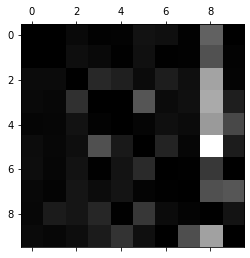

In [96]:
plt.matshow(norm_conf_mat, cmap=plt.cm.gray)
plt.show()

In [131]:
import matplotlib as mpl
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")


In [108]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

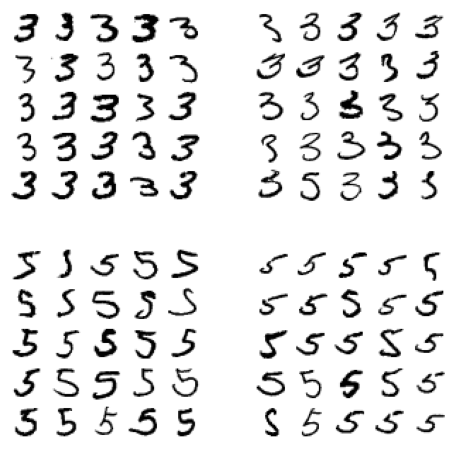

In [133]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25].to_numpy(), images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25].to_numpy(), images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25].to_numpy(), images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25].to_numpy(), images_per_row=5)
plt.show()

In [134]:
y_large = (y_train >= 7)

In [135]:
y_odd = (y_train % 2 == 1)

In [137]:
y_multiclass = np.c_[y_large, y_odd]

In [138]:
y_multiclass

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]])

In [139]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()

In [140]:
knn_clf.fit(X_train, y_multiclass)

KNeighborsClassifier()

In [141]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [142]:
y_multiclass_knn_pred = cross_val_predict(knn_clf, X_train, y_multiclass, cv=3)

In [143]:
f1_score(y_multiclass, y_multiclass_knn_pred, average='macro')

0.976410265560605

In [154]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [155]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

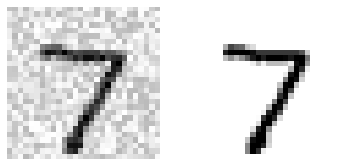

In [167]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod.iloc[some_index].values)
plt.subplot(122); plot_digit(y_test_mod.iloc[some_index].values)
plt.show()

In [168]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

In [172]:
clean_image = knn_clf.predict([X_test_mod.iloc[some_index]])

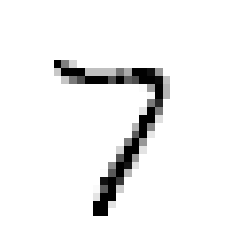

In [174]:
plot_digit(clean_image)

<h1>Exercises</h1>

## 1

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
60000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
